In [39]:
%matplotlib inline


# "torch.nn" Gerçekten Nedir?

[torch.nn](https://pytorch.org/docs/stable/nn.html) ,
[torch.optim](https://pytorch.org/docs/stable/optim.html) ,
[Dataset](https://pytorch.org/docs/stable/data.html?highlight=dataset#torch.utils.data.Dataset) ,
[DataLoader](https://pytorch.org/docs/stable/data.html?highlight=dataloader#torch.utils.data.DataLoader)

In [40]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/main/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

In [41]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

## Mnist dataseti



(50000, 784)


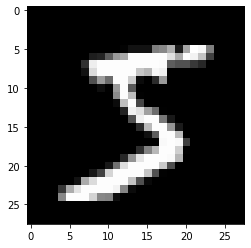

In [42]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

**kural:** PyTorch, numpy dizileri yerine ``torch.tensor`` kullanır, bu yüzden
verilerimizi dönüştürmemiz gerekir.



In [43]:
import torch
x_train, y_train, x_valid, y_valid = map(torch.tensor, (x_train, y_train, x_valid, y_valid))

n, c = x_train.shape

print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


## Sıfırdan Sinir Ağı (torch.nn yok)


In [44]:
import math

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)
# Ağırlıklar için başlatma işleminden **sonra** ``requires_grad`` ayarını yapıyoruz,
# çünkü o adımın degradeye dahil edilmesini istemiyorum.

In [7]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias) # @ işareti matris çarpımını ifade eder.
# ağırlıklar rastgele başlatıldığı için kayıp yüksek olacaktır.

In [45]:
bs = 64  # batch size

xb = x_train[0:bs]  # a mini-batch from x
preds = model(xb)  # predictions
preds[0], preds.shape
print(preds[0], preds.shape)

tensor([ 1.0428, -4.8143,  0.5872,  6.3145, -6.5423,  6.6169, -1.4252,  0.2232,
        -1.4130,  0.1012], grad_fn=<SelectBackward0>) torch.Size([64, 10])


In [46]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

In [47]:
yb = y_train[0:bs]
print(loss_func(preds, yb))

tensor(-8.7879, grad_fn=<NegBackward0>)


In [48]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [49]:
print(accuracy(preds, yb))

tensor(0.9375)


Artık bir eğitim döngüsü çalıştırabiliriz. Her yineleme için şunları yapacağız:

- küçük bir veri grubu seçin (of size ``bs``)
- tahminlerde bulunmak için modeli kullanın
- kaybı hesapla
- ``loss.backward()`` modelin gradyanlarını günceller, bu durumda ağırlıklar ve bias güncellenir.

In [ ]:
from IPython.core.debugger import set_trace

lr = 0.5  # learning rate
epochs = 2  # epoch -- kaç döngü ? 

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        #set_trace()
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

In [52]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(-8.7879, grad_fn=<NegBackward0>) tensor(0.9375)


In [53]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias

In [54]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(2.3920, grad_fn=<NllLossBackward0>) tensor(0.0625)


## nn.Module


In [55]:
from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, xb):
        return xb @ self.weights + self.bias

In [56]:
model = Mnist_Logistic()

In [57]:
print(loss_func(model(xb), yb))

tensor(2.3429, grad_fn=<NllLossBackward0>)


In [58]:
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()

fit()

Let's double-check that our loss has gone down:



In [59]:
print(loss_func(model(xb), yb))

tensor(0.2313, grad_fn=<NllLossBackward0>)


## nn.Linear
[nn.Linear](https://pytorch.org/docs/stable/nn.html#linear-layers)


In [60]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)

    def forward(self, xb):
        return self.lin(xb)

We instantiate our model and calculate the loss in the same way as before:



In [61]:
model = Mnist_Logistic()
print(loss_func(model(xb), yb))

tensor(2.3431, grad_fn=<NllLossBackward0>)


In [62]:
fit()

print(loss_func(model(xb), yb))

tensor(0.2249, grad_fn=<NllLossBackward0>)


## optim


In [63]:
from torch import optim

We'll define a little function to create our model and optimizer so we
can reuse it in the future.



In [64]:
def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

model, opt = get_model()
print(loss_func(model(xb), yb))

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(2.3275, grad_fn=<NllLossBackward0>)
tensor(0.0814, grad_fn=<NllLossBackward0>)


## Dataset




In [65]:
from torch.utils.data import TensorDataset

In [66]:
train_ds = TensorDataset(x_train, y_train)

In [67]:
model, opt = get_model()

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        xb, yb = train_ds[i * bs: i * bs + bs]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0801, grad_fn=<NllLossBackward0>)


## DataLoader




In [68]:
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

### önceden eğitim döngümüz bu şekildeydi.
      for i in range((n-1)//bs + 1):
          xb,yb = train_ds[i*bs : i*bs+bs]
          pred = model(xb)

### şimdi dataloader ile bu işlem daha kolay.
      for xb,yb in train_dl:
          pred = model(xb)



In [69]:
model, opt = get_model()

for epoch in range(epochs):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0813, grad_fn=<NllLossBackward0>)



## Doğrulama Ekleme.


In [70]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

# shuffle yani karıştırma veriler içindeki korelasyonu kullanmak adına önemlidir.
# valid sekmesinde shuffle yapmamızın bir önemi yok. ekstradan zaman kaybına da gerek yok.

In [71]:
model, opt = get_model()

for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)

    print(epoch, valid_loss / len(valid_dl))

0 tensor(0.2880)
1 tensor(0.3089)


## fit() ve get_data() oluşturmak.

Şimdi kendi başımıza küçük bir yeniden düzenleme yapacağız. Hem eğitim seti hem de doğrulama seti için kaybı hesaplamanın iki katı benzer bir süreçten geçtiğimizden, bunu bir parti için kaybı hesaplayan kendi işlevi olan loss_batch'e dönüştürelim.

Eğitim seti için bir optimize ediciden geçiyoruz ve bunu backprop gerçekleştirmek için kullanıyoruz. Doğrulama kümesi için bir iyileştiriciyi geçmiyoruz, bu nedenle yöntem geri yayılım gerçekleştirmiyor.



In [72]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

`fıt`, modelimizi eğitmek ve her dönem için eğitim ve doğrulama kayıplarını hesaplamak için gerekli işlemleri yürütür.



In [73]:
import numpy as np

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)

`get_data`, eğitim ve doğrulama kümeleri için dataloader'ları döndürür.



In [74]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

şimdi bu fonksiyonlarımızı birleştirelim. bu durumda dataloader'larımız ve modelimizi eğitmek için 3 satırlık kod yeterli olacaktır.



In [75]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.3013431036949158
1 0.3273642091095448


Çok çeşitli modelleri eğitmek için bu temel 3 kod satırını kullanabilirsiniz.
Bakalım onları evrişimli bir sinir ağını (CNN) eğitmek için kullanabilir miyiz!

## CNN


In [76]:
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))

lr = 0.1

[Momentum](https://cs231n.github.io/neural-networks-3/#sgd) is a variation on
stochastic gradient descent that takes previous updates into account as well
and generally leads to faster training.



In [77]:
model = Mnist_CNN()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.3810607476234436
1 0.28974757410287855


## nn.Sequential
[Sequential](https://pytorch.org/docs/stable/nn.html#torch.nn.Sequential)
Sıralı bir nesne, içinde bulunan modüllerin her birini sıralı bir şekilde çalıştırır. Bu, sinir ağımızı yazmanın daha basit bir yoludur.

In [78]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)


def preprocess(x):
    return x.view(-1, 1, 28, 28)

In [79]:
model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.377224178981781
1 0.29274727516174315


## CNN'lerde WrappedDataLoader Kullanma.


In [80]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28), y


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

In [81]:
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [82]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.30294544947147367
1 0.26278236931562426


## GPU Kullanma.


In [83]:
print(torch.cuda.is_available())

False


In [84]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

In [85]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28).to(dev), y.to(dev)


train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

In [86]:
model.to(dev)
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [87]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.18122531248927115
1 0.17618359094560146


## Özet.

  - **torch.nn**

    + ``Module``: bir işlev gibi davranan bir çağrılabilir oluşturur, ancak aynı zamanda
      durum içerir (sinir ağları katman ağırlıkları gibi). Hangi ``Parameter``(s)'ları içerir ve tüm gradyanlarını sıfırlayabilir, ağırlık güncellemeleri vb. için bunlar arasında geçiş yapabilir.
    + ``Parameter``: backprop sırasında Module güncellenmesi gereken ağırlıkları söyler. Yalnızca **"requires_grad"** öznitelik kümesine sahip tensörler güncellenir.
    + `functional`: modül içinde bulunan (genellikle "F" adı ile import edilir.)
      aktivasyon fonksiyonlarını, kayıp fonksiyonlarını vb. içeren ve ayrıca durum bilgisi olmayan evrişimli ve doğrusal katmanlar gibi katmanların versiyonlarını içerir.
  - ``torch.optim``: ``SGD`` gibi optimize ediciler içerir geri adım sırasında parametre deki ağırlıkları güncelleyen optimize edicileri içerisinde bulundurur.
  - ``Dataset``: ``__len__`` ve ``__getitem__`` içeren nesnelerin soyut arayüzü,``TensorDataset`` gibi Pytorch ile sağlanan sınıflar dahil dataset nesneleri tutulur.
  - `DataLoader:` Herhangi bir "Veri Kümesi"ni alır ve toplu veri döndüren bir yineleyici oluşturur.